In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import skimage.io as skio
import torch.optim as optim
import skimage as sk
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data = np.load(f"lego_200x200.npz")
images_train = data["images_train"] / 255.0
c2ws_train = data["c2ws_train"]
images_val = data["images_val"] / 255.0
c2ws_val = data["c2ws_val"]
c2ws_test = data["c2ws_test"]
focal = data["focal"]

(100, 200, 200, 3)


In [4]:
height = 200
width = 200
n_samples = 32

In [5]:
K = np.array([[focal,0,width/2],[0,focal,height/2],[0,0,1]])

In [7]:
# c2w = c2ws_train[0]

In [8]:
# c2w

In [6]:
def transform(c2w, x_c):
    #camera to world
    num_rows = len(x_c)
    ones_column = np.ones((num_rows, 1))
    x_c_with_one = np.concatenate((x_c, ones_column), axis=1)
    x = (c2w @ x_c_with_one.T).T
    return x[:,:-1]

In [10]:
aaa = np.array([[0,0,0]])
print(transform(c2w, aaa))

[[-0.05379832  3.84547043  1.20808232]]


In [11]:
w2c = np.linalg.inv(c2w)

In [11]:
print(-np.linalg.inv(w2c[:3,:3]) @ w2c[:3,3])

[-0.05379832  3.84547043  1.20808232]


In [7]:
def pixel_to_camera(K, uv,s):
    num_rows = len(uv)
    ones_column = np.ones((num_rows, 1))
    uv_with_one = np.concatenate((uv, ones_column), axis=1)
    result = (np.linalg.inv(K) @ uv_with_one.T).T
    return result

In [63]:
aaa = np.array([[1,2,3],[10,11,12],[20,21,22],[21,22,23]])
b = np.array([[0.9,2,3]])
c = aaa - b
norms = np.linalg.norm(c, axis=1, keepdims=True)
print(norms)
print(c/norms)

[[ 0.1       ]
 [15.64640534]
 [32.96680148]
 [34.69884724]]
[[1.         0.         0.        ]
 [0.58160324 0.57521199 0.57521199]
 [0.57937073 0.57633738 0.57633738]
 [0.57926996 0.57638802 0.57638802]]


In [8]:
def pixel_to_ray(K, c2w, uv):
    zeros = np.array([[0,0,0]])
    origin = transform(c2w, zeros)
    depth_1_points = pixel_to_camera(K, uv, 1)
    world_depth_1_points = transform(c2w, depth_1_points)
    world_depth_1_points_direction = world_depth_1_points - origin
    norms = np.linalg.norm(world_depth_1_points_direction, axis=1, keepdims=True)
    directions = world_depth_1_points_direction/ norms

    return origin, directions
    

In [9]:
class RaysData(Dataset):
    def __init__(self, img_train, K, c2ws_train):
        self.img = img_train
        self.c2ws = c2ws_train
        self.K = K
        self.height = 200
        self.width = 200
        self.length = len(self.img) * self.height * self.width

    def __len__(self):
        return len(self.img * self.height * self.width)
    
    def __getitem__(self, idx):
        pass
        # x = idx // self.width 
        # y = idx % self.width 
        # rgb = [self.image[x,y,0],
        #        self.image[x,y,1],
        #        self.image[x,y,2]]
        # sample = {'input':torch.tensor([x/self.height,y/ self.width]),
        #           "label":torch.tensor(rgb)}
        # return sample

    def sample_rays(self, num_samples):
        rays_o = []
        rays_d = []
        pixels = []
        random_numbers = [random.randint(0,self.length -1) for _ in range(num_samples)]
        for random_number in random_numbers:
            img_index = random_number // (self.width*self.height)
            residual = random_number % (self.width*self.height)
            temp_height = residual // self.height
            temp_width = residual % self.width
            c2w = self.c2ws[img_index]
            uv = np.array([[temp_height, temp_width]])
            ray_o, ray_d = pixel_to_ray(self.K, c2w, uv)
            rays_o.append(ray_o[0])
            rays_d.append(ray_d[0])
            pixels.append(self.img[img_index,temp_height,temp_width,:])
        return rays_o, rays_d,pixels
    

In [10]:
dataset = RaysData(images_train, K, c2ws_train)
# rays_o, rays_d, pixels = dataset.sample_rays(5)

In [40]:
# def sample_along_rays(rays_o, rays_d, perturb = True):
#     far = 6 
#     near = 2
#     n_samples = 32
#     points = []
#     for ray_o, ray_d in zip(rays_o, rays_d):
#         for t in np.linspace(near, far, n_samples):
#             ran = random.uniform(0, (far - near)/n_samples)
#             p_t = t + ran
#             points.append(ray_o + ray_d * p_t)
#     return np.array(points)

In [11]:
def sample_along_rays(rays_o, rays_d, n_samples = 32, perturb = True):
    far = 6 
    near = 2
    points = []
    for ray_o, ray_d in zip(rays_o, rays_d):
        for t in np.linspace(near, far, n_samples):
            ran = random.uniform(0, (far - near)/n_samples)
            p_t = t + ran
            points.append(ray_o + ray_d * p_t)
    return np.array(points)

In [17]:
# points = sample_along_rays(rays_o, rays_d)
# print(len(points))

In [17]:


import viser, time  # pip install viser
import numpy as np

# --- You Need to Implement These ------
dataset = RaysData(images_train, K, c2ws_train)
rays_o, rays_d, pixels = dataset.sample_rays(5)
points = sample_along_rays(rays_o, rays_d, perturb=True)
H, W = images_train.shape[1:3]

In [17]:
server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
    server.add_camera_frustum(
        f"/cameras/{i}",
        fov=2 * np.arctan2(H / 2, K[0, 0]),
        aspect=W / H,
        scale=0.15,
        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
        position=c2w[:3, 3],
        image=image
    )
for i, (o, d) in enumerate(zip(rays_o, rays_d)):
    server.add_spline_catmull_rom(
        f"/rays/{i}", positions=np.stack((o, o + d * 6.0)),
    )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points).reshape(-1, 3),
    points=points.reshape(-1, 3),
    point_size=0.02,
)
time.sleep(1000)

(viser) Share URL requested! (expires in 24 hours)

╭───────────────────────────── viser ──────────────────────────────╮
│             ╷                                                    │
│   HTTP      │ http://0.0.0.0:8080                                │
│   Websocket │ ws://0.0.0.0:8080                                  │
│   Share URL │ https://transparent-augmented.share.viser.studio   │
│             ╵                                                    │
╰──────────────────────────────────────────────────────────────────╯

(viser) Connection opened (0, 1 total), 411 persistent messages

(viser) Connection closed (0, 0 total)

KeyboardInterrupt: 

In [12]:
def volrend(sigmas, rgbs, step_size):
    sigmas = sigmas.to(device)
    rgbs = rgbs.to(device)
    size_to_prepend = (sigmas.size(0), 1, 1)

    zeros_to_prepend = torch.zeros(size_to_prepend, dtype=sigmas.dtype).to(device)
    
    tensor_with_zeros = torch.cat((zeros_to_prepend, sigmas), dim=1).to(device)

    
    
    cum_sigmas = torch.cumsum(tensor_with_zeros,dim=1)[:,:-1].to(device)
    T = torch.exp(-cum_sigmas*step_size).to(device)
    interval_sigmas = 1 - torch.exp(-sigmas*step_size).to(device)
    weights = T * interval_sigmas
    colors = rgbs * weights
    cum_colors = torch.sum(colors, dim=1).to(device)

    return cum_colors

In [13]:
torch.manual_seed(42)
sigmas = torch.rand((10, 64, 1)) * 1000
rgbs = torch.rand((10, 64, 3))
step_size = (6.0 - 2.0) / 64
rendered_colors = volrend(sigmas, rgbs, step_size)
correct = torch.tensor([
  [0.6020, 0.0316, 0.9366],
  [0.0620, 0.2249, 0.1381],
  [0.7785, 0.4253, 0.7124],
  [0.8748, 0.5055, 0.7411],
  [0.2240, 0.5240, 0.4298],
  [0.0531, 0.7500, 0.0501],
  [0.0458, 0.9415, 0.4620],
  [0.6692, 0.3450, 0.0991],
  [0.7392, 0.6365, 0.3080],
  [0.2425, 0.9346, 0.9305]]
).to(device)
assert torch.allclose(rendered_colors, correct, rtol=1e-4, atol=1e-4)

In [19]:
class Nerf_model(nn.Module):
    def __init__(self,high_fre_level, high_fre_level_angle, hidden_dim):
        super(Nerf_model, self).__init__()
        self.high_fre_level = high_fre_level
        self.high_fre_level_angle = high_fre_level_angle
        self.pe_dim = 3+high_fre_level*6
        self.pe_dim_angle = 3 + 6 * high_fre_level_angle
        self.input_layer = nn.Linear(3+high_fre_level*6, hidden_dim)
        # self.input_layer = nn.Linear(2, hidden_dim)
        hidden_layer_list = []
        for i in range(3):
            hidden_layer_list.append(nn.Linear(hidden_dim, hidden_dim))
            hidden_layer_list.append(nn.ReLU())
        self.hidden_layer_1 = nn.Sequential(*hidden_layer_list)

        self.concat_hidden_layer = nn.Linear(hidden_dim + self.pe_dim,hidden_dim)
        
        hidden_layer_list = []
        for i in range(2):
            hidden_layer_list.append(nn.Linear(hidden_dim, hidden_dim))
            hidden_layer_list.append(nn.ReLU())
        self.hidden_layer_2 = nn.Sequential(*hidden_layer_list)

        self.hidden_layer_3 = nn.Linear(hidden_dim, hidden_dim)
        self.hidden_layer_4 = nn.Linear(hidden_dim, hidden_dim)
        self.hidden_layer_5 = nn.Linear(hidden_dim, hidden_dim)
        self.hidden_layer_concat_angle = nn.Linear(hidden_dim + self.pe_dim_angle, hidden_dim//2)

        self.out = nn.Linear(hidden_dim//2, 3)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.angle_layer = nn.Linear(hidden_dim, 1)

    def positional_encoding(self, data, high_fre_level):
        d = data.shape[1]
        length = len(data)
        data = data.to(device)
        pe = torch.zeros(length, high_fre_level*2*d).to(device)
        div_term = torch.exp2(torch.arange(0, high_fre_level))*3.14159
        div_term = div_term.to(device)
        for i in range(len(data)):
            for j in range(d):
                pe[i, 2*j*high_fre_level:high_fre_level*(j+1)*2:2] = torch.sin(data[i,j] * div_term)
                pe[i, 1 + 2*j*high_fre_level:high_fre_level*(j+1)*2+1:2] = torch.cos(data[i,j] * div_term)
        return pe
        
    def forward_phase_1(self, origin_x):
        # print(origin_x.dtype)
        x = self.input_layer(origin_x)
        x = self.relu(x)
        x = self.hidden_layer_1(x)
        x = torch.cat((x,origin_x), dim = 1)
        x = self.concat_hidden_layer(x)
        x = self.relu(x)
        x = self.hidden_layer_2(x)
        x = self.hidden_layer_3(x)
        return x

    # def foward_dentisy(self, origin_x):
    #     x = forward_phase_1(origin_x)
    #     return self.angle_layer(x)
        
    def forward(self, pos, angle):
        pos_pe = self.positional_encoding(pos, self.high_fre_level)
        origin_x = torch.cat((pos,pos_pe),dim=1).float()
        x = self.forward_phase_1(origin_x)
        x = self.hidden_layer_4(x)
        sigmas = self.angle_layer(x)
        sigmas = self.relu(sigmas)
        
        x = self.hidden_layer_5(x)
        angle_pe = self.positional_encoding(angle, self.high_fre_level_angle)
        angle_input = torch.cat((angle,angle_pe),dim=1)
        concated_x = torch.cat((x,angle_input), dim = 1).float()
        x = self.hidden_layer_concat_angle(concated_x)
        x = self.relu(x)
        x = self.out(x)
        x = self.sigmoid(x)
        return x, sigmas
        

In [161]:
# optimizer = optim.Adam(model.parameters(),lr=0.001)
# criterion = PSNRWithMSELoss()
# criterion = torch.nn.MSELoss()
# number_iteration  = 1000
# for i in range(number_iteration):
#     dataset = RaysData(images_train, K, c2ws_train)
#     rays_o, rays_d, pixels = dataset.sample_rays(10)
#     points = sample_along_rays(rays_o, rays_d)
#     points = torch.tensor(points).to(device)
#     rays_d = torch.tensor(rays_d).to(device)
    
#     rays_d = torch.unsqueeze(rays_d,1)
#     rays_d = rays_d.repeat(1,n_samples,1)
#     rays_d = rays_d.view(-1,3)
    
#     rgbs, sigmas = model(points, rays_d)
#     # sigams = model.foward_dentisy()
#     sigmas = sigmas.view(-1,n_samples,1)
#     rgbs = rgbs.view(-1,n_samples,3)
#     rendered_colors = volrend(sigmas, rgbs, step_size)
#     pixels = torch.tensor(pixels).float().to(device)
#     loss = criterion(rendered_colors, pixels)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     # if (i_batch) % 10000 == 0:
#     print(f'iteration [{i}], Loss: {loss.item()}')

4
torch.Size([320, 3])
torch.Size([320, 27])
torch.Size([320, 283])
iteration [0], Loss: 0.10159755498170853
4
torch.Size([320, 3])
torch.Size([320, 27])
torch.Size([320, 283])
iteration [1], Loss: 0.17140106856822968
4
torch.Size([320, 3])
torch.Size([320, 27])
torch.Size([320, 283])
iteration [2], Loss: 0.09804832935333252
4
torch.Size([320, 3])
torch.Size([320, 27])
torch.Size([320, 283])
iteration [3], Loss: 0.14086276292800903
4
torch.Size([320, 3])
torch.Size([320, 27])
torch.Size([320, 283])
iteration [4], Loss: 0.06375943124294281
4
torch.Size([320, 3])
torch.Size([320, 27])
torch.Size([320, 283])
iteration [5], Loss: 0.06186775863170624
4
torch.Size([320, 3])
torch.Size([320, 27])
torch.Size([320, 283])
iteration [6], Loss: 0.09290654957294464
4
torch.Size([320, 3])
torch.Size([320, 27])
torch.Size([320, 283])
iteration [7], Loss: 0.090561643242836
4
torch.Size([320, 3])
torch.Size([320, 27])
torch.Size([320, 283])
iteration [8], Loss: 0.07159743458032608
4
torch.Size([320, 3]

KeyboardInterrupt: 

In [138]:
# ttt = torch.tensor(([1,2,3],[4,5,6],[7,8,9],[10,11,12],[13,14,15],[16,17,18]))
# tttt = ttt.view(-1,3,3)
# print(tttt.shape)
# print(tttt)

aaaa = torch.tensor(([[1,2,3],[4,5,6]]))
aaaaa = torch.unsqueeze(aaaa,1)
print(aaaaa.shape)
aaaaa = aaaaa.repeat(1,5,1)
print(aaaaa.shape)
aaaaaa = aaaaa.view(-1,3)
print(aaaaaa)

torch.Size([2, 1, 3])
torch.Size([2, 5, 3])
tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [4, 5, 6],
        [4, 5, 6],
        [4, 5, 6],
        [4, 5, 6],
        [4, 5, 6]])


In [20]:
class PSNRWithMSELoss(nn.Module):
    def __init__(self):
        super(PSNRWithMSELoss, self).__init__()
        
    def forward(self, predicted, target):
        # mse_loss = nn.MSELoss()(predicted, target)
        # mse_loss = nn.MSELoss()(predicted, target)
        # psnr = 10 * torch.log10(1 / mse_loss)
        mse_loss = torch.mean((predicted - target) ** 2)
        psnr = 10 * torch.log10(1 / mse_loss)
        return psnr

In [21]:
model = Nerf_model(10,4,256).to(device)
step_size = (6-2)/n_samples

In [22]:
optimizer = optim.Adam(model.parameters())
# criterion = PSNRWithMSELoss()
criterion = torch.nn.MSELoss()
number_iteration  = 10
model.train()
for i in range(number_iteration):
    dataset = RaysData(images_train, K, c2ws_train)
    rays_o, rays_d, pixels = dataset.sample_rays(10000)
    points = sample_along_rays(rays_o, rays_d)
    points = torch.tensor(points).to(device)
    rays_d = torch.tensor(rays_d).to(device)
    
    rays_d = torch.unsqueeze(rays_d,1)
    rays_d = rays_d.repeat(1,n_samples,1)
    rays_d = rays_d.view(-1,3)
    
    rgbs, sigmas = model(points, rays_d)
    rgbs = rgbs.to(device)
    sigmas = sigmas.to(device)
    # sigams = model.foward_dentisy()
    sigmas = sigmas.view(-1, n_samples, 1)
    rgbs = rgbs.view(-1, n_samples, 3)
    rendered_colors = volrend(sigmas, rgbs, step_size)
    pixels = torch.tensor(pixels).float().to(device)
    loss = criterion(rendered_colors, pixels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # if (i_batch) % 10000 == 0:
    print(f'iteration [{i}], Loss: {loss.item()}')

2023-11-02 19:46:30.392780: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 19:46:30.515437: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 19:46:31.250190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_4247/2814496965.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  rays_d = torch.tensor(rays_d).to(device)


KeyboardInterrupt: 

In [69]:
# uv = []
# for i in range(200):
#     uv.append([0,i])
# uv = np.array(uv)
# ray_o, ray_d = pixel_to_ray(K, c2w_eval, uv)

In [93]:
model.eval()
eval_height = 50
eval_width = 50
c2w_eval = c2ws_train[0]
results = torch.zeros((eval_height, eval_width,3)).to(device)
for i in range(eval_height):
    uv = []
    for j in range(eval_width):
        uv.append([i,j])
    ray_o, ray_d = pixel_to_ray(K, c2w_eval, uv)
    rays_o = np.repeat(ray_o, eval_height, axis=0)
    rays_d = list(ray_d)
    points = sample_along_rays(rays_o, rays_d)
    points = torch.tensor(points).to(device)
    rays_d = torch.tensor(rays_d).to(device)
    rays_d = torch.unsqueeze(rays_d,1)
    rays_d = rays_d.repeat(1,n_samples,1)
    rays_d = rays_d.view(-1,3)
    
    rgbs, sigmas = model(points, rays_d)
    rgbs = rgbs.to(device)
    sigmas = sigmas.to(device)
    # sigams = model.foward_dentisy()
    sigmas = sigmas.view(-1, n_samples, 1)
    rgbs = rgbs.view(-1, n_samples, 3)
    rendered_colors = volrend(sigmas, rgbs, step_size)
    # print(rendered_colors.shape)
    results[i,:,:] = rendered_colors

/home/yihua/anaconda3/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


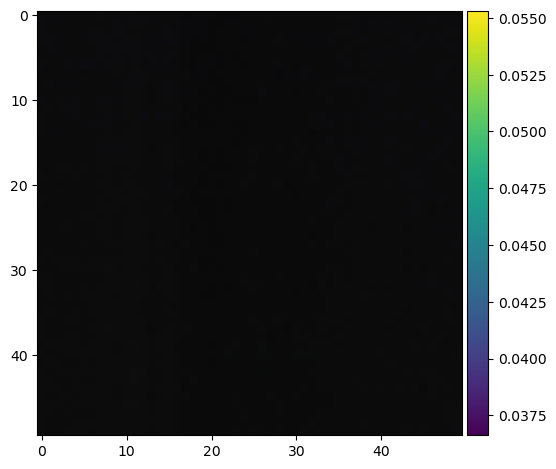

In [95]:
results = results.detach().cpu().numpy()
skio.imshow(results)